In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.optimize import curve_fit

## Q1 Part 1:

In [2]:
df = pd.read_csv('adoptionseries2_with_noise.csv')
df.rename(columns = {'N(t)':'N'}, inplace = True)

In [3]:
df['A'] = df['N'].cumsum() - df['N']
df['A_sq'] = np.square(df['A'])
df

,t,N,A,A_sq
0,1,0.123,0.000,0.000000
1,2,0.097,0.123,0.015129
2,3,0.171,0.220,0.048400
3,4,0.145,0.391,0.152881
4,5,0.238,0.536,0.287296
5,6,0.214,0.774,0.599076
6,7,0.333,0.988,0.976144
7,8,0.314,1.321,1.745041
8,9,0.466,1.635,2.673225
9,10,0.455,2.101,4.414201


In [4]:
model1 = smf.ols(formula = 'N ~ A + A_sq', data = df).fit()
print(model1.summary())

                            OLS Regression Results                            
Dep. Variable:                      N   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                     188.4
Date:                Mon, 10 Apr 2023   Prob (F-statistic):           3.09e-09
Time:                        13:53:40   Log-Likelihood:                 23.404
No. Observations:                  14   AIC:                            -40.81
Df Residuals:                      11   BIC:                            -38.89
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0961      0.027      3.611      0.0

/Users/sarvaripidaparty/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [5]:
a = model1.params[0]
b = model1.params[1]
c = model1.params[2]
d = np.sqrt(np.square(b) - 4*a*c)

In [6]:
p = (d - b)/2
q = (d + b)/2
M = -q/c

In [7]:
print(round(p,3), round(q,3), round(M,3))

0.003 0.214 34.405


In [8]:
#extrapolating the data for t=15 to t=30, taking t=14 data as initial data
t = 1

T = 17

A = np.zeros(T)
N = np.zeros(T)
R = np.zeros(T)
F = np.zeros(T)

def bass_func(t, p, q, T):
    for i in range(t, T):
        A[i] = N[i-1] + A[i-1]
        R[i] = M - A[i]
        F[i] = p + q * A[i]/M
        N[i] = F[i] * R[i]
    return A, N

A[0] = 4.761
R[0] = M - A[0]
F[0] = p + q*A[0]/M
N[0] = 0.926

A, N = bass_func(t, p, q, T)
print(N[16]*1000000)

973841.4756158367


## Q1 Part 2:

In [9]:
M = 100

def N0(df, p, q):
    return ((M*p) + ((q - p)*df['A']) - ((q/M)*df['A_sq']))

x_var = df[['A','A_sq']] #create a subset of the dataframe to get the independent variables
y_var = df['N']
popt, pcov = curve_fit(N0, xdata = x_var, ydata = y_var, p0=[0.02, 0.5])

In [10]:
#p
p = popt[0]
round(p,3)

0.001

In [11]:
#q
q = popt[1]
round(q,3)

0.194

## Q1 Part 3:

In [12]:
A1, N1 = bass_func(t, p, q, T)
print(N1[16]*1000000)

4890439.591951741


## Q1 Part 4:

In [13]:
def N0_cont(t, p, q):
    E = np.exp(-1*(p + q)*t)
    Et = np.exp(-1*(p + q)*(t-1))
    Ac = M * ((1 - E) / (1 + ((q/p)*E)))
    Act = M * ((1 - Et) / (1 + ((q/p)*Et)))
    return Ac - Act

x_var1 = df['t']
y_var1 = df['N']
popt4, pcov4 = curve_fit(N0_cont, xdata = x_var1, ydata = y_var1, p0=[0.02, 0.5])

In [14]:
#p
p = popt4[0]
round(p,3)

0.001

In [15]:
#q
q = popt4[1]
round(q,3)

0.179

In [16]:
N2 = N0_cont(29, p, q)
print(N2*1000000)

4494517.937185485


***

## Q4

In [17]:
#concatenating the original data with extrapolated data (discrete case)
p, q = 0.01, 0.1
NA = np.stack((N1, A1), axis=1)
df1 = pd.DataFrame(NA, columns =['N', 'A'])
df1 = df1.drop(labels=0, axis=0)
df1['t'] = range(15,31)
df1['A_sq'] = np.square(df1['A'])

df2 = pd.concat([df, df1], ignore_index=True, sort=False)

In [18]:
def cont_N(t, p, q): #function to generate continuous bass values
    N = np.zeros(30)
    A = np.zeros(30)
    for t in range(0,30):
        E = np.exp(-1*(p + q)*t)
        Et = np.exp(-1*(p + q)*(t-1))
        Ac = M * ((1 - E) / (1 + ((q/p)*E)))
        Act = M * ((1 - Et) / (1 + ((q/p)*Et)))
        A[t] = Ac
        N[t] = Ac - Act
    return A, N

A3, N3 = cont_N(30, p, q)

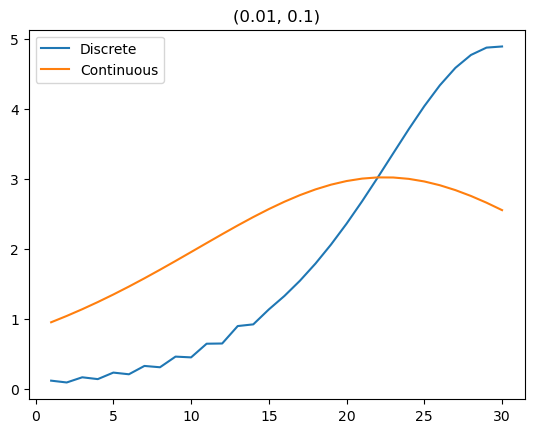

In [19]:
plt.figure()
plt.plot(df2['t'], df2['N'], label = "Discrete")
plt.plot(df2['t'], N3, label = "Continuous")
plt.title(label = (p, q))
plt.legend()

In [20]:
p1, q1 = 0.01, 0.5
A4, N4 = bass_func(t, p1, q1, T)
NA1 = np.stack((N4, A4), axis=1)
df3 = pd.DataFrame(NA1, columns =['N', 'A'])
df3 = df3.drop(labels=0, axis=0)
df3['t'] = range(15,31)
df3['A_sq'] = np.square(df3['A'])
df4 = pd.concat([df, df3], ignore_index=True, sort=False)

A5, N5 = cont_N(30, p1, q1)

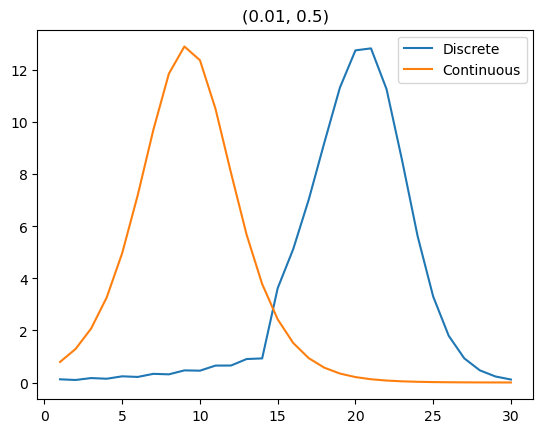

In [21]:
plt.figure()
plt.plot(df4['t'], df4['N'], label = "Discrete")
plt.plot(df4['t'], N5, label = "Continuous")
plt.title(label = (p1, q1))
plt.legend()

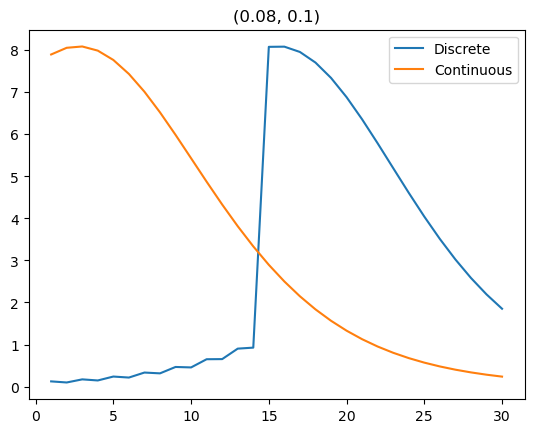

In [22]:
p2, q2 = 0.08, 0.1
A6, N6 = bass_func(t, p2, q2, T)
NA2 = np.stack((N6, A6), axis=1)
df5 = pd.DataFrame(NA2, columns =['N', 'A'])
df5 = df5.drop(labels=0, axis=0)
df5['t'] = range(15,31)
df5['A_sq'] = np.square(df5['A'])
df6 = pd.concat([df, df5], ignore_index=True, sort=False)

A7, N7 = cont_N(30, p2, q2)

plt.figure()
plt.plot(df6['t'], df6['N'], label = "Discrete")
plt.plot(df6['t'], N7, label = "Continuous")
plt.title(label = (p2, q2))
plt.legend()

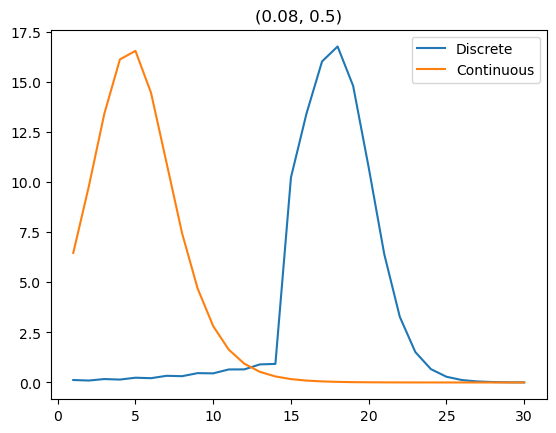

In [23]:
p3, q3 = 0.08, 0.5
A8, N8 = bass_func(t, p3, q3, T)
NA3 = np.stack((N8, A8), axis=1)
df7 = pd.DataFrame(NA3, columns =['N', 'A'])
df7 = df7.drop(labels=0, axis=0)
df7['t'] = range(15,31)
df7['A_sq'] = np.square(df7['A'])
df8 = pd.concat([df, df7], ignore_index=True, sort=False)

A9, N9 = cont_N(30, p3, q3)

plt.figure()
plt.plot(df8['t'], df8['N'], label = "Discrete")
plt.plot(df8['t'], N9, label = "Continuous")
plt.title(label = (p3, q3))
plt.legend()

## Q5

In [24]:
df['X1'] = M - df['A']
df['X2'] = df['A'] - (df['A_sq']/M)

In [25]:
model2 = smf.ols(formula = 'N ~ X1 + X2 - 1', data = df).fit() #-1 in the formula to get rid of the intercept
print(model2.summary())

                                 OLS Regression Results                                
Dep. Variable:                      N   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                              662.7
Date:                Mon, 10 Apr 2023   Prob (F-statistic):                    5.22e-13
Time:                        13:53:40   Log-Likelihood:                          23.181
No. Observations:                  14   AIC:                                     -42.36
Df Residuals:                      12   BIC:                                     -41.08
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/Users/sarvaripidaparty/opt/anaconda3/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [26]:
p = round(model2.params[0],3)
q = round(model2.params[1],3)
p, q

(0.001, 0.194)